# Genereative Adversarial Networks

Let us now try to build a Generative Adversarial Network using just numpy.

## Imports

In [1]:
import numpy as np
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import math

## Load Dataset

For this example we will be using the mnist dataset. So let us define a function to load the dataset from file, as well as one-hot encode the labels.

In [2]:
def mnist_reader(numbers):
    def one_hot(label, output_dim):
        one_hot = np.zeros((len(label), output_dim))
        
        for idx in range(0,len(label)):
            one_hot[idx, label[idx]] = 1
        
        return one_hot


    #Training Data
    f = open('./data/mnist/train-images.idx3-ubyte')
    loaded = np.fromfile(file=f, dtype=np.uint8)
    trainX = loaded[16:].reshape((60000, 28, 28, 1)).astype(np.float32) /  127.5 - 1


    f = open('./data/mnist/train-labels.idx1-ubyte')
    loaded = np.fromfile(file=f, dtype=np.uint8)
    trainY = loaded[8:].reshape((60000)).astype(np.int32)

    newtrainX = []
    for idx in range(0,len(trainX)):
        if trainY[idx] in numbers:
            newtrainX.append(trainX[idx])

    return np.array(newtrainX), trainY, len(trainX) 

# Introduction to Generative Adversarial Networks


Generative adversarial networks consist of two models: a generative model and a discriminative model.

![alt_image](https://pathmind.com/images/wiki/gan_schema.png)

The discriminator model is a classifier that determines whether a given image looks like a real image from the dataset or like an artificially created image. This is basically a binary classifier that will take the form of a normal convolutional neural network (CNN).

The generator model takes random input values and transforms them into images through a deconvolutional neural network.

Over the course of many training iterations, the weights and biases in the discriminator and the generator are trained through backpropagation. The discriminator learns to tell "real" images of handwritten digits apart from "fake" images created by the generator. At the same time, the generator uses feedback from the discriminator to learn how to produce convincing images that the discriminator can't distinguish from real images.

## GAN Algorithm

**Step 1.** We take some noise from random distribution , then we feed it to the Generator G to produce the fake x (label y=0) → (x,y) input-label pair.

**Step 2.** We take this fake pair and the real pair x (label y =1) and feed it to the Discriminator D alternatively.

**Step 3.** The discriminator D is a binary classification neural network so it calculates the loss for both fake x and real x and combine them as the final loss as D loss.

**Step 4.** The generator G also calculates the loss from it’s noise as G loss since each network has a different objective function.

**Step 5.** The two losses go back to their respective networks to learn from the loss (adjusting the parameters w r t the loss)

**Step 6.** Apply any optimization algorithm (Grad descent, ADAM, RMS prop, etc..) Repeat this process for certain no of epochs or as long as you wish.

Each network has goals so these two networks pit against each other during the training.
The generator G gets stronger and stronger at generating the real type of results and the discriminator D also gets stronger and stronger at identifying which one is real , which one is fake.

## Math of GAN

As we know the discriminator is a binary classifier so when we feed the real data , the model should produce high probability for the real data and low probability for fake data( generator’s output)
so let me define the variables and functions

![alt_image](https://miro.medium.com/max/1400/1*EE0QzfFXqdBIEdqUuwaxsQ.jpeg)

as you can see the D(x), D(G(z)) give a score between 0 and 1,
we want to build a model (discriminator) that maximizes the real data while minimizing the fake data.
and G(z) gives the same shape of the real input(ex: if image of 10*10 is the real input then G(z) produces the same shape but of course it’s noisy.
and also we want to build a model(generator) that maximizes the fake data.
here are the equations to paint a picture.

![alt_image](https://miro.medium.com/max/2000/1*EzDzBJfoTYy9TKJFDzd0mw.jpeg)

as you can see the discriminator network runs twice (one for real , one for fake) before it calculates the final loss while generator runs only once.
Once we got these two losses, we calculate the gradients w r t their parameters and back propagate through their networks independently .
From the paper by Ian here is the final equation in terms of expectation.
D and G play the following two-player mini-max game with value function V (G, D):

![alt_image](https://miro.medium.com/max/2000/1*sgZS5dgbVNW0Riath3HtBg.png)

![alt_image](https://miro.medium.com/max/1400/1*kfv9DdO_zhYjbeHViPh8WA.jpeg)

Note: I strongly recommend you to check the paper right after this ( I am adding snippet from the paper for now down).

![alt_image](https://miro.medium.com/max/1400/1*edsoaOwCb6LhhJNpG2qAjQ.png)

## Activation Function

Let us define a few activation functions and their derivatives for the network to use.

In [3]:
#Sigmoid
def sigmoid(input, derivative=False):
    res = 1/(1+np.exp(-input))
    if derivative:
        return res*(1-res)
    return res

#ReLu
def relu(input, derivative=False):
    res = input
    if derivative:
        return 1.0 * (res > 0)
    else:
        return res * (res > 0)
    
#Leaky ReLu
def lrelu(input, alpha=0.01, derivative=False):
    res = input
    if derivative:
        dx = np.ones_like(res)
        dx[res < 0] = alpha
        return dx
    else:
        return np.maximum(input, input*alpha, input)

#Hyperbolic Tangent
def tanh(input, derivative=False):
    res = np.tanh(input)
    if derivative:
        return 1.0 - np.tanh(input) ** 2
    return res


## Image Visualization

Let us also define a function to visualize the generated images

In [4]:
def img_tile(imgs, path, epoch, step, name, save=False, aspect_ratio=1.0, tile_shape=None, border=1, border_color=0):
    if imgs.ndim != 3 and imgs.ndim != 4:
        raise ValueError('imgs has wrong number of dimensions.')
    n_imgs = imgs.shape[0]

    tile_shape = None
    # Grid shape
    img_shape = np.array(imgs.shape[1:3])
    if tile_shape is None:
        img_aspect_ratio = img_shape[1] / float(img_shape[0])
        aspect_ratio *= img_aspect_ratio
        tile_height = int(np.ceil(np.sqrt(n_imgs * aspect_ratio)))
        tile_width = int(np.ceil(np.sqrt(n_imgs / aspect_ratio)))
        grid_shape = np.array((tile_height, tile_width))
    else:
        assert len(tile_shape) == 2
        grid_shape = np.array(tile_shape)

    # Tile image shape
    tile_img_shape = np.array(imgs.shape[1:])
    tile_img_shape[:2] = (img_shape[:2] + border) * grid_shape[:2] - border

    # Assemble tile image
    tile_img = np.empty(tile_img_shape)
    tile_img[:] = border_color
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            img_idx = j + i*grid_shape[1]
            if img_idx >= n_imgs:
                # No more images - stop filling out the grid.
                break

            #-1~1 to 0~1
            img = (imgs[img_idx] + 1)/2.0# * 255.0

            yoff = (img_shape[0] + border) * i
            xoff = (img_shape[1] + border) * j
            tile_img[yoff:yoff+img_shape[0], xoff:xoff+img_shape[1], ...] = img 


    path_name = path + "/epoch_%03d"%(epoch)+".jpg"

    ##########################################
    # Change code below if you want to save results using PIL
    ##########################################
    tile_img = cv2.resize(tile_img, (256,256))
    #cv2.imshow(name, tile_img)
    #cv2.waitKey(1)
    plt.imshow(tile_img, cmap='Greys_r')
    plt.show()
    if save:
        cv2.imwrite(path_name, tile_img*255)

## GAN: The Model

Let us now define the GAN class. It should contain the Generator and the Discriminator, with their individual back prop functions. It should also contain the training loop that forward propogates the network and optimizes the loss functions using gradient from the backprop. 

In [5]:
epsilon = 10e-8
class GAN(object):
    def __init__(self, numbers, epochs):
        self.numbers = numbers

        self.epochs = epochs
        self.batch_size = 64
        self.learning_rate = 0.001
        self.decay = 0.001

        self.img_path = "./images"
        if not os.path.exists(self.img_path):
            os.makedirs(self.img_path)


        # Xavier initialization is used to initialize the weights
        # https://theneuralperspective.com/2016/11/11/weights-initialization/
        # init generator weights
        self.g_W0 = np.random.randn(100,128).astype(np.float32) * np.sqrt(2.0/(100))
        self.g_b0 = np.zeros(128).astype(np.float32)

        self.g_W1 = np.random.randn(128,784).astype(np.float32) * np.sqrt(2.0/(128))
        self.g_b1 = np.zeros(784).astype(np.float32)

        # init discriminator weights
        self.d_W0 = np.random.randn(784,128).astype(np.float32) * np.sqrt(2.0/(784))
        self.d_b0 = np.zeros(128).astype(np.float32)

        self.d_W1 = np.random.randn(128,1).astype(np.float32) * np.sqrt(2.0/(128))
        self.d_b1 = np.zeros(1).astype(np.float32)

    def discriminator(self, img):
        #self.d_h{num}_l : hidden logit layer
        #self.d_h{num}_a : hidden activation layer

        self.d_input = np.reshape(img, (self.batch_size,-1))

        self.d_h0_l = self.d_input.dot(self.d_W0) + self.d_b0
        self.d_h0_a = lrelu(self.d_h0_l)

        self.d_h1_l = self.d_h0_a.dot(self.d_W1) + self.d_b1
        self.d_h1_a = sigmoid(self.d_h1_l)
        self.d_out = self.d_h1_a

        return self.d_h1_l, self.d_out

    def generator(self, z):
        #self.g_h{num}_l : hidden logit layer
        #self.g_h{num}_a : hidden activation layer

        self.z = np.reshape(z, (self.batch_size, -1))

        self.g_h0_l = self.z.dot(self.g_W0) + self.g_b0
        self.g_h0_a = lrelu(self.g_h0_l)

        self.g_h1_l = self.g_h0_a.dot(self.g_W1) + self.g_b1
        self.g_h1_a = tanh(self.g_h1_l)

        self.g_out = np.reshape(self.g_h1_a, (self.batch_size, 28, 28))

        return self.g_h1_l, self.g_out


    # generator backpropagation
    def backprop_gen(self,
                     fake_logit,
                     fake_output,
                     fake_input,
                    ):
        # fake_logit : logit output from the discriminator D(G(z))
        # fake_output : sigmoid output from the discriminator D(G(z))

        # flatten fake image input
        fake_input = np.reshape(fake_input, (self.batch_size,-1))

        # calculate the derivative of the loss term -log(D(G(z)))
        g_loss = np.reshape(fake_output, (self.batch_size, -1))
        g_loss = -1.0/(g_loss+ epsilon)

        # calculate the gradients from the end of the discriminator
        # we calculate them but won't update the discriminator weights
        loss_deriv = g_loss*sigmoid(fake_logit, derivative=True)
        loss_deriv = loss_deriv.dot(self.d_W1.T)

        loss_deriv = loss_deriv*lrelu(self.d_h0_l, derivative=True)
        loss_deriv = loss_deriv.dot(self.d_W0.T)
        # Reached the end of the generator

        # Calculate generator gradients
        #######################################
        #fake input gradients
        #-log(D(G(z)))
        #######################################
        loss_deriv = loss_deriv*tanh(self.g_h1_l, derivative=True)
        prev_layer = np.expand_dims(self.g_h0_a, axis=-1)
        loss_deriv_ = np.expand_dims(loss_deriv, axis=1)
        grad_W1 = np.matmul(prev_layer,loss_deriv_)
        grad_b1 = loss_deriv

        loss_deriv = loss_deriv.dot(self.g_W1.T)
        loss_deriv = loss_deriv*lrelu(self.g_h0_l, derivative=True)
        prev_layer = np.expand_dims(self.z, axis=-1)
        loss_deriv_ = np.expand_dims(loss_deriv, axis=1)
        grad_W0 = np.matmul(prev_layer,loss_deriv_)
        grad_b0 = loss_deriv

        # calculated all the gradients in the batch
        # now make updates
        for idx in range(self.batch_size):
            self.g_W0 = self.g_W0 - self.learning_rate*grad_W0[idx]
            self.g_b0 = self.g_b0 - self.learning_rate*grad_b0[idx]

            self.g_W1 = self.g_W1 - self.learning_rate*grad_W1[idx]
            self.g_b1 = self.g_b1 - self.learning_rate*grad_b1[idx]


    # discriminator backpropagation
    def backprop_dis(self,
                     real_logit, real_output, real_input,
                     fake_logit, fake_output, fake_input,
                     ):
        # real_logit : real logit value before sigmoid activation function (real input)
        # real_output : Discriminator output in range 0~1 (real input)
        # real_input : real input image fed into the discriminator
        # fake_logit : fake logit value before sigmoid activation function (generated input)
        # fake_output : Discriminator output in range 0~1 (generated input)
        # fake_input : fake input image fed into the discriminator

        real_input = np.reshape(real_input, (self.batch_size,-1))
        fake_input = np.reshape(fake_input, (self.batch_size,-1))

        # Discriminator loss = -np.mean(log(D(x)) + log(1-D(G(z))))
        # Calculate gradients of the loss
        d_real_loss = -1.0/(real_output + epsilon)
        d_fake_loss = -1.0/(fake_output - 1.0 + epsilon)

        # start from the error in the last layer
        #######################################
        #       real input gradients
        #       -log(D(x))
        #######################################
        loss_deriv = d_real_loss*sigmoid(real_logit, derivative=True)
        prev_layer = np.expand_dims(self.d_h0_a, axis=-1)
        loss_deriv_ = np.expand_dims(loss_deriv, axis=1)
        grad_real_W1 =  np.matmul(prev_layer,loss_deriv_)
        grad_real_b1 = loss_deriv

        loss_deriv = loss_deriv.dot(self.d_W1.T)
        loss_deriv = loss_deriv*lrelu(self.d_h0_l, derivative=True)
        prev_layer = np.expand_dims(real_input, axis=-1)
        loss_deriv_ = np.expand_dims(loss_deriv, axis=1)
        grad_real_W0 = np.matmul(prev_layer,loss_deriv_)
        grad_real_b0 = loss_deriv

        #######################################
        #       fake input gradients
        #       -log(1 - D(G(z)))
        #######################################
        loss_deriv = d_fake_loss*sigmoid(fake_logit, derivative=True)
        prev_layer = np.expand_dims(self.d_h0_a, axis=-1)
        loss_deriv_ = np.expand_dims(loss_deriv, axis=1)
        grad_fake_W1 = np.matmul(prev_layer,loss_deriv_)
        grad_fake_b1 = loss_deriv

        loss_deriv = loss_deriv.dot(self.d_W1.T)
        loss_deriv = loss_deriv*lrelu(self.d_h0_l, derivative=True)
        prev_layer = np.expand_dims(fake_input, axis=-1)
        loss_deriv_ = np.expand_dims(loss_deriv, axis=1)
        grad_fake_W0 = np.matmul(prev_layer,loss_deriv_)
        grad_fake_b0 = loss_deriv


        # combine two gradients (real + fake)
        grad_W1 = grad_real_W1 + grad_fake_W1
        grad_b1 = grad_real_b1 + grad_fake_b1

        grad_W0 = grad_real_W0 + grad_fake_W0
        grad_b0 = grad_real_b0 + grad_fake_b0

        # calculated all the gradients in the batch
        # now make updates
        for idx in range(self.batch_size):
            self.d_W0 = self.d_W0 - self.learning_rate*grad_W0[idx]
            self.d_b0 = self.d_b0 - self.learning_rate*grad_b0[idx]

            self.d_W1 = self.d_W1 - self.learning_rate*grad_W1[idx]
            self.d_b1 = self.d_b1 - self.learning_rate*grad_b1[idx]


    def train(self):
        #we don't need labels.
        #just read images and shuffle
        trainX, _, train_size = mnist_reader(self.numbers)
        np.random.shuffle(trainX)

        #set batch indices
        batch_idx = train_size//self.batch_size
        for epoch in range(self.epochs+1):
            for idx in range(batch_idx):
                # prepare batch and input vector z
                train_batch = trainX[idx*self.batch_size:idx*self.batch_size + self.batch_size]
                #ignore batch if there are insufficient elements
                if train_batch.shape[0] != self.batch_size:
                    break

                z = np.random.uniform(-1,1,[self.batch_size,100])

                ################################
                #		Forward Pass
                ################################
                g_logits, fake_img = self.generator(z)

                d_real_logits, d_real_output = self.discriminator(train_batch)
                d_fake_logits, d_fake_output = self.discriminator(fake_img)

                # cross entropy loss using sigmoid output
                # add epsilon to avoid overflow
                # maximize Discriminator loss = -np.mean(log(D(x)) + log(1-D(G(z))))
                d_loss = -np.log(d_real_output+epsilon) - np.log(1 - d_fake_output+epsilon)

                # Generator loss
                # ver1 : minimize log(1 - D(G(z)))
                # ver2 : maximize -log(D(G(z))) #this is better
                g_loss = -np.log(d_fake_output+epsilon)


                ################################
                #		Backward Pass
                ################################
                # for every result in the batch
                # calculate gradient and update the weights using Adam

                # discriminator backward pass
                # one for fake input, another for real input
                self.backprop_dis(d_real_logits, d_real_output, train_batch, d_fake_logits, d_fake_output, fake_img)

                # generator backward pass
                self.backprop_gen(d_fake_logits, d_fake_output, fake_img)
                # train generator twice?
                #g_logits, fake_img = self.generator(z)
                #d_fake_logits, d_fake_output = self.discriminator(fake_img)
                #self.backprop_gen(d_fake_logits, d_fake_output, fake_img)

                #show res images as tile
                #if you want to see the result at every step, uncomment line below
                #img_tile(np.array(fake_img), self.img_path, epoch, idx, "res", False)
                self.img = fake_img

            #update learning rate every epoch
            self.learning_rate = self.learning_rate * (1.0/(1.0 + self.decay*epoch))
            #self.learning_rate = self.learning_rate * math.exp(-0.1*epoch)
            
            #save image result every epoch
            img_tile(np.array(self.img), self.img_path, epoch, idx, "res")
            
            print("Epoch [%d] G Loss:%.4f D Loss:%.4f Real Ave.: %.4f Fake Ave.: %.4f lr: %.4f"%(epoch, np.mean(g_loss), np.mean(d_loss), np.mean(d_real_output), np.mean(d_fake_output), self.learning_rate))

Once we have the network defined, we can start the training.

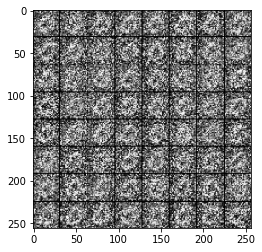

Epoch [0] G Loss:0.8419 D Loss:1.1268 Real Ave.: 0.5704 Fake Ave.: 0.4313 lr: 0.0010


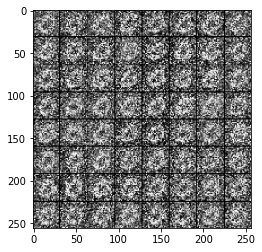

Epoch [1] G Loss:0.7693 D Loss:1.1024 Real Ave.: 0.6194 Fake Ave.: 0.4635 lr: 0.0010


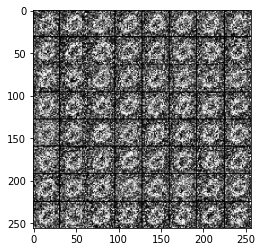

Epoch [2] G Loss:0.8584 D Loss:1.0608 Real Ave.: 0.6013 Fake Ave.: 0.4240 lr: 0.0010


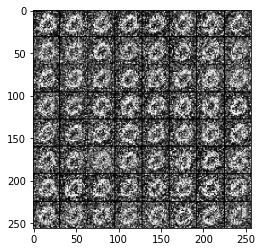

Epoch [3] G Loss:0.8628 D Loss:1.0661 Real Ave.: 0.5965 Fake Ave.: 0.4223 lr: 0.0010


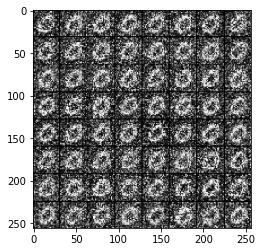

Epoch [4] G Loss:0.8471 D Loss:1.0892 Real Ave.: 0.5896 Fake Ave.: 0.4289 lr: 0.0010


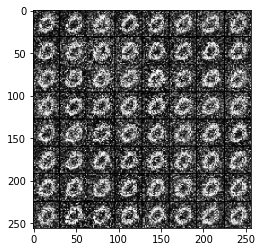

Epoch [5] G Loss:0.8326 D Loss:1.1167 Real Ave.: 0.5802 Fake Ave.: 0.4353 lr: 0.0010


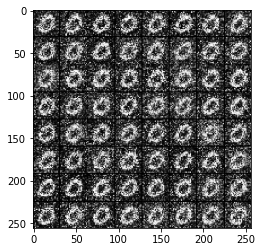

Epoch [6] G Loss:0.8184 D Loss:1.1469 Real Ave.: 0.5693 Fake Ave.: 0.4415 lr: 0.0010


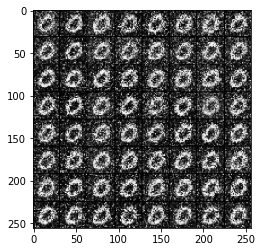

Epoch [7] G Loss:0.7977 D Loss:1.1819 Real Ave.: 0.5589 Fake Ave.: 0.4507 lr: 0.0010


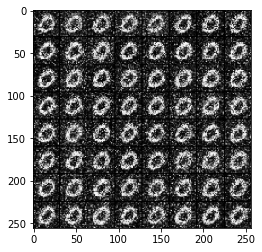

Epoch [8] G Loss:0.7798 D Loss:1.2140 Real Ave.: 0.5492 Fake Ave.: 0.4587 lr: 0.0010


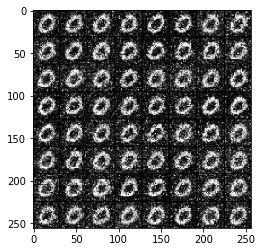

Epoch [9] G Loss:0.7739 D Loss:1.2349 Real Ave.: 0.5407 Fake Ave.: 0.4615 lr: 0.0010


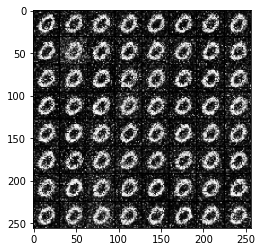

Epoch [10] G Loss:0.7518 D Loss:1.2674 Real Ave.: 0.5336 Fake Ave.: 0.4718 lr: 0.0009


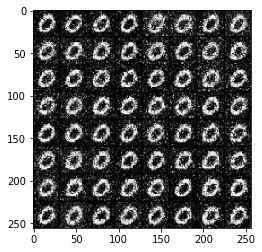

Epoch [11] G Loss:0.7484 D Loss:1.2829 Real Ave.: 0.5270 Fake Ave.: 0.4734 lr: 0.0009


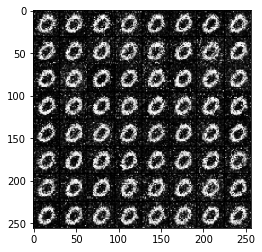

Epoch [12] G Loss:0.7389 D Loss:1.3011 Real Ave.: 0.5219 Fake Ave.: 0.4779 lr: 0.0009


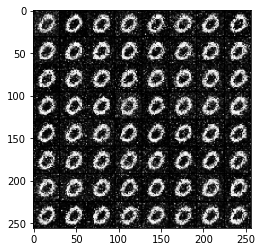

Epoch [13] G Loss:0.7258 D Loss:1.3205 Real Ave.: 0.5180 Fake Ave.: 0.4841 lr: 0.0009


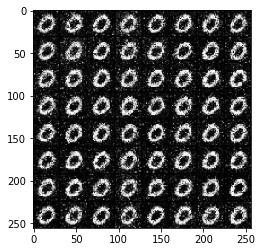

Epoch [14] G Loss:0.7222 D Loss:1.3302 Real Ave.: 0.5147 Fake Ave.: 0.4858 lr: 0.0009


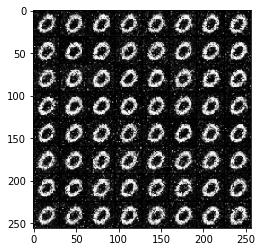

Epoch [15] G Loss:0.7149 D Loss:1.3427 Real Ave.: 0.5117 Fake Ave.: 0.4893 lr: 0.0009


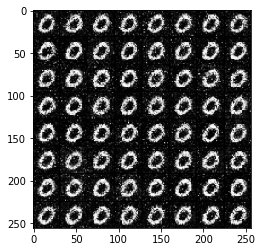

Epoch [16] G Loss:0.7137 D Loss:1.3483 Real Ave.: 0.5093 Fake Ave.: 0.4899 lr: 0.0009


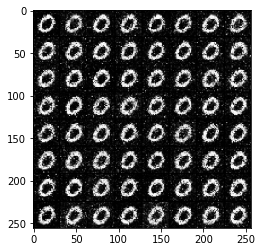

Epoch [17] G Loss:0.7070 D Loss:1.3576 Real Ave.: 0.5079 Fake Ave.: 0.4932 lr: 0.0009


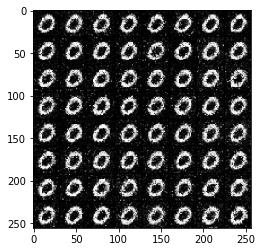

Epoch [18] G Loss:0.7065 D Loss:1.3610 Real Ave.: 0.5064 Fake Ave.: 0.4934 lr: 0.0008


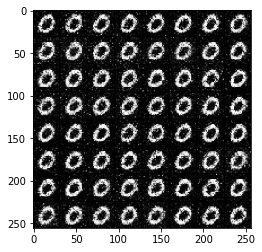

Epoch [19] G Loss:0.7074 D Loss:1.3621 Real Ave.: 0.5054 Fake Ave.: 0.4930 lr: 0.0008


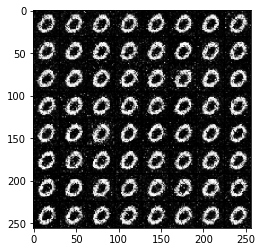

Epoch [20] G Loss:0.7041 D Loss:1.3672 Real Ave.: 0.5043 Fake Ave.: 0.4946 lr: 0.0008


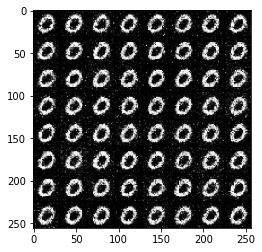

Epoch [21] G Loss:0.7025 D Loss:1.3695 Real Ave.: 0.5040 Fake Ave.: 0.4954 lr: 0.0008


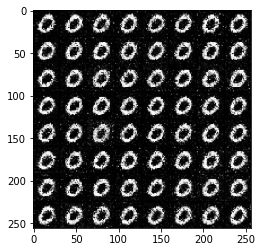

Epoch [22] G Loss:0.7029 D Loss:1.3698 Real Ave.: 0.5036 Fake Ave.: 0.4952 lr: 0.0008


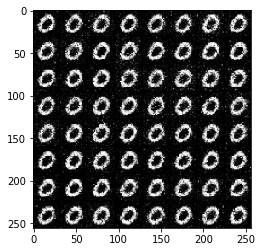

Epoch [23] G Loss:0.7017 D Loss:1.3714 Real Ave.: 0.5034 Fake Ave.: 0.4958 lr: 0.0008


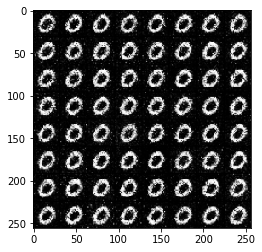

Epoch [24] G Loss:0.6987 D Loss:1.3742 Real Ave.: 0.5034 Fake Ave.: 0.4972 lr: 0.0007


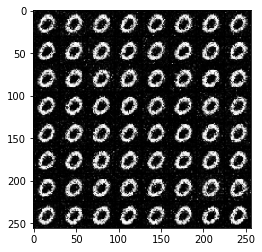

Epoch [25] G Loss:0.6997 D Loss:1.3737 Real Ave.: 0.5032 Fake Ave.: 0.4968 lr: 0.0007


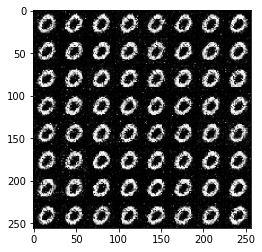

Epoch [26] G Loss:0.6994 D Loss:1.3736 Real Ave.: 0.5033 Fake Ave.: 0.4969 lr: 0.0007


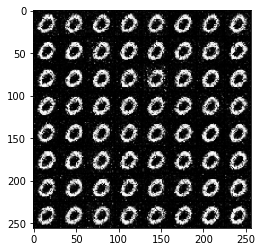

Epoch [27] G Loss:0.7005 D Loss:1.3725 Real Ave.: 0.5034 Fake Ave.: 0.4964 lr: 0.0007


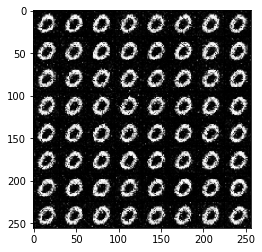

Epoch [28] G Loss:0.7016 D Loss:1.3711 Real Ave.: 0.5035 Fake Ave.: 0.4958 lr: 0.0007


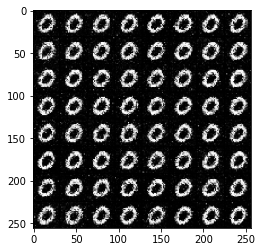

Epoch [29] G Loss:0.7008 D Loss:1.3716 Real Ave.: 0.5036 Fake Ave.: 0.4962 lr: 0.0006


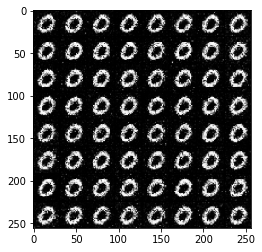

Epoch [30] G Loss:0.6994 D Loss:1.3727 Real Ave.: 0.5038 Fake Ave.: 0.4969 lr: 0.0006


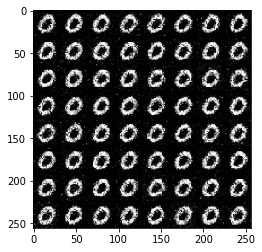

Epoch [31] G Loss:0.7021 D Loss:1.3699 Real Ave.: 0.5039 Fake Ave.: 0.4956 lr: 0.0006


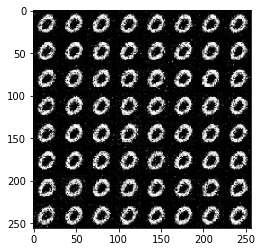

Epoch [32] G Loss:0.7013 D Loss:1.3704 Real Ave.: 0.5040 Fake Ave.: 0.4959 lr: 0.0006


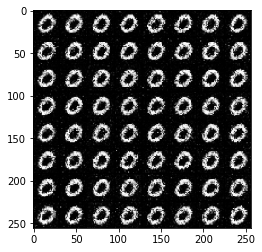

Epoch [33] G Loss:0.7014 D Loss:1.3700 Real Ave.: 0.5041 Fake Ave.: 0.4959 lr: 0.0006


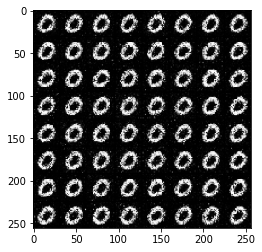

Epoch [34] G Loss:0.7009 D Loss:1.3704 Real Ave.: 0.5042 Fake Ave.: 0.4962 lr: 0.0006


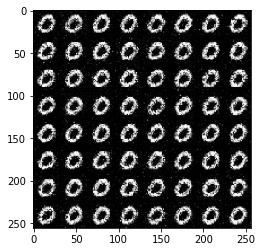

Epoch [35] G Loss:0.7023 D Loss:1.3690 Real Ave.: 0.5042 Fake Ave.: 0.4954 lr: 0.0005


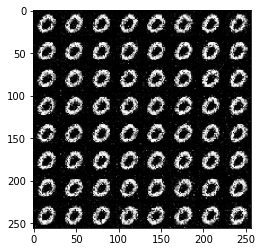

Epoch [36] G Loss:0.7023 D Loss:1.3688 Real Ave.: 0.5043 Fake Ave.: 0.4955 lr: 0.0005


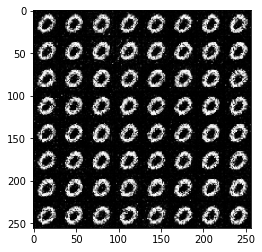

Epoch [37] G Loss:0.7025 D Loss:1.3686 Real Ave.: 0.5043 Fake Ave.: 0.4953 lr: 0.0005


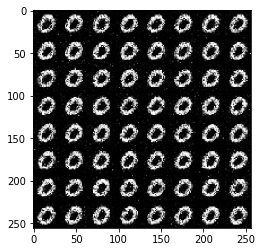

Epoch [38] G Loss:0.7024 D Loss:1.3686 Real Ave.: 0.5043 Fake Ave.: 0.4954 lr: 0.0005


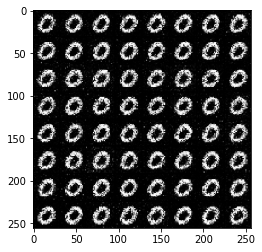

Epoch [39] G Loss:0.7028 D Loss:1.3681 Real Ave.: 0.5044 Fake Ave.: 0.4952 lr: 0.0005


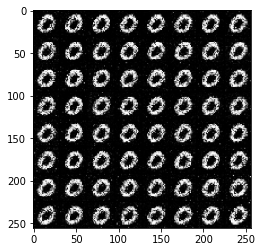

Epoch [40] G Loss:0.7021 D Loss:1.3689 Real Ave.: 0.5044 Fake Ave.: 0.4956 lr: 0.0004


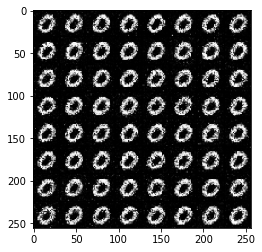

Epoch [41] G Loss:0.7017 D Loss:1.3694 Real Ave.: 0.5043 Fake Ave.: 0.4958 lr: 0.0004


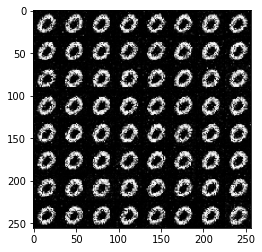

Epoch [42] G Loss:0.7031 D Loss:1.3682 Real Ave.: 0.5042 Fake Ave.: 0.4951 lr: 0.0004


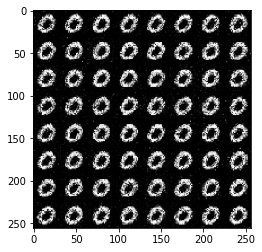

Epoch [43] G Loss:0.7018 D Loss:1.3695 Real Ave.: 0.5042 Fake Ave.: 0.4957 lr: 0.0004


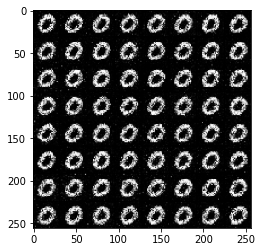

Epoch [44] G Loss:0.7017 D Loss:1.3697 Real Ave.: 0.5041 Fake Ave.: 0.4958 lr: 0.0004


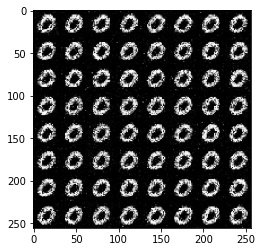

Epoch [45] G Loss:0.7014 D Loss:1.3701 Real Ave.: 0.5041 Fake Ave.: 0.4959 lr: 0.0004


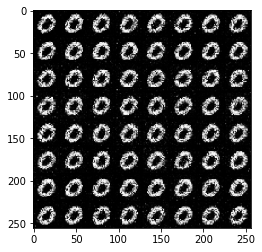

Epoch [46] G Loss:0.7008 D Loss:1.3708 Real Ave.: 0.5040 Fake Ave.: 0.4962 lr: 0.0003


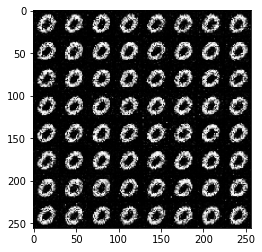

Epoch [47] G Loss:0.7017 D Loss:1.3702 Real Ave.: 0.5039 Fake Ave.: 0.4958 lr: 0.0003


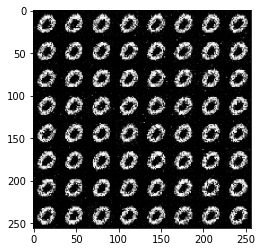

Epoch [48] G Loss:0.7014 D Loss:1.3706 Real Ave.: 0.5038 Fake Ave.: 0.4959 lr: 0.0003


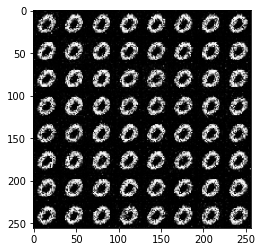

Epoch [49] G Loss:0.7003 D Loss:1.3719 Real Ave.: 0.5037 Fake Ave.: 0.4964 lr: 0.0003


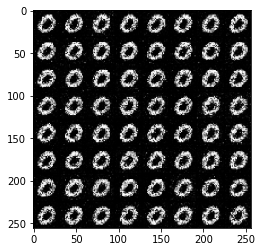

Epoch [50] G Loss:0.7023 D Loss:1.3703 Real Ave.: 0.5036 Fake Ave.: 0.4955 lr: 0.0003


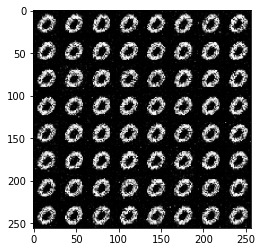

Epoch [51] G Loss:0.7009 D Loss:1.3717 Real Ave.: 0.5035 Fake Ave.: 0.4962 lr: 0.0003


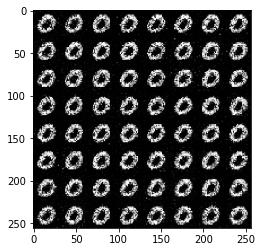

Epoch [52] G Loss:0.7002 D Loss:1.3725 Real Ave.: 0.5035 Fake Ave.: 0.4965 lr: 0.0003


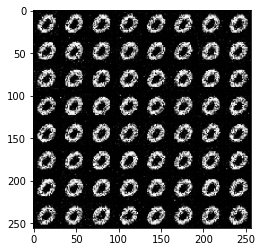

Epoch [53] G Loss:0.6992 D Loss:1.3738 Real Ave.: 0.5034 Fake Ave.: 0.4970 lr: 0.0002


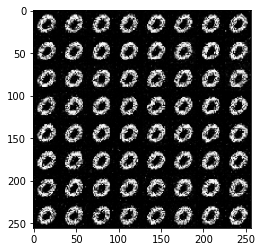

Epoch [54] G Loss:0.6987 D Loss:1.3745 Real Ave.: 0.5032 Fake Ave.: 0.4972 lr: 0.0002


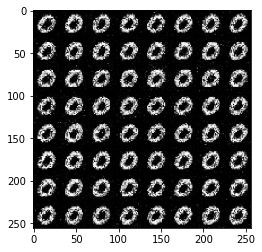

Epoch [55] G Loss:0.6992 D Loss:1.3742 Real Ave.: 0.5031 Fake Ave.: 0.4970 lr: 0.0002


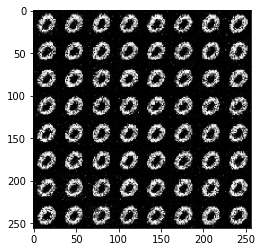

Epoch [56] G Loss:0.6995 D Loss:1.3740 Real Ave.: 0.5031 Fake Ave.: 0.4969 lr: 0.0002


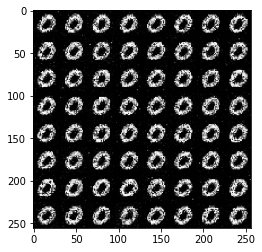

Epoch [57] G Loss:0.6987 D Loss:1.3750 Real Ave.: 0.5030 Fake Ave.: 0.4973 lr: 0.0002


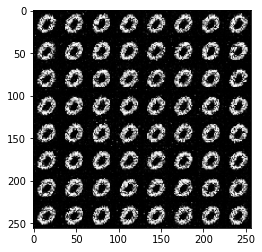

Epoch [58] G Loss:0.6985 D Loss:1.3754 Real Ave.: 0.5029 Fake Ave.: 0.4973 lr: 0.0002


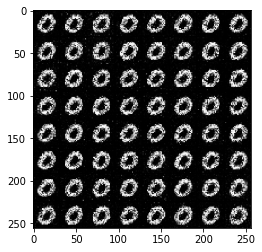

Epoch [59] G Loss:0.7006 D Loss:1.3735 Real Ave.: 0.5028 Fake Ave.: 0.4963 lr: 0.0002


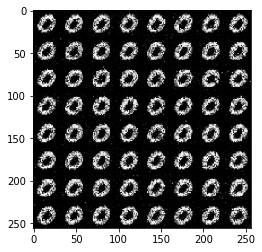

Epoch [60] G Loss:0.6990 D Loss:1.3753 Real Ave.: 0.5027 Fake Ave.: 0.4971 lr: 0.0002


In [6]:
# Choose the numbers to train on the GAN
numbers = [0]
epochs = 60
gan = GAN(numbers, epochs)
gan.train()

As you can see, the simple GAN is able to produce digits that look very similar to the actual ones with enough training. If using multiple digits it requires more number of training epochs.